In [23]:

from xbbg import blp

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter

import numpy as np
import pandas as pd
import seaborn as sns

import datetime
from dateutil.relativedelta import relativedelta
from datetime import timedelta

In [2]:
def hist_data(tickers, start_date, end_date, condition = "LAST_PRICE"):
    # Return a matrix of prices, with modifiable pricing condition
    data = blp.bdh(tickers, condition, start_date,end_date)
    data = data.dropna()
    clean_cols = []
    for col in data.columns:
        clean_cols.append(col[0])
    data.columns = clean_cols
    return data

In [35]:
def hist_intraday_series(pair, fix_code, start_date, end_date):
    times = ["000", "003", "010", "013", "020", "023", "030", "033", "040","043","050", "053","060", "063",
            "070", "073", "080", "083", "090", "093", "100", "103", "110", "113", "120", "123", "130", "133",
            "140", "143", "150", "153", "160", "163", "170", "173", "180", "183", "190", "193", 
             "200", "203", "210", "213", "220", "223", "230", "233"]
    matrix = []
    for time in times:
        pair_fix = pair + " " + fix_code + time + " CURNCY"
        df = hist_data(pair_fix, start_date, end_date)
        df = df.dropna()
        if time in ["173", "180", "190", "200", "210", "220", "230",
                   "183", "193", "203", "213", "223", "233"]:
            df["temp"] = df.index
            df["temp"] = df["temp"].apply(lambda x: reindex(x))
            df.index = df["temp"]
            df = df.drop(columns = "temp")
        matrix.append(df)
    dates = []
    times = []
    val = []
    for index in matrix[0].index:
        for sub_df in matrix:
            if index in sub_df.index:
                hour = int(sub_df.columns[0][8:10])
                minute = int(sub_df.columns[0][10])*10
                time_of_day = datetime.time(hour, minute)
                time_long = datetime.datetime.combine(index, time_of_day)
                dates.append(time_long)
                times.append(sub_df.columns[0][8:11])
                val.append(sub_df.loc[index].values[0])
    df_dict = {"Value" : val}
    frame = pd.DataFrame(index = dates, data = df_dict)
    return frame

In [36]:
USDJPY = (hist_intraday_series("USDJPY", "F", "2022-01-01", "2022-07-22"))


In [37]:
print(USDJPY)

                       Value
2022-01-03 00:00:00  115.275
2022-01-03 00:30:00  115.290
2022-01-03 01:00:00  115.310
2022-01-03 01:30:00  115.355
2022-01-03 02:00:00  115.325
...                      ...
2022-07-22 15:00:00  136.180
2022-07-22 15:30:00  136.140
2022-07-22 16:00:00  136.045
2022-07-22 16:30:00  136.050
2022-07-22 17:00:00  136.085

[6535 rows x 1 columns]


In [38]:
def tz(hour):
    if hour >= 0 and hour <=2:
        tz = "ASIA"
    elif hour> 2 and hour <= 4:
        tz = "ASIALON"
    elif hour > 4 and hour <= 7:
        tz = "LON"
    elif hour> 7 and hour <= 12:
        tz = "LONNY"
    elif hour> 12 and hour <= 17:
        tz = "NY"
    elif hour >17:
        tz = "ASIA"
    return tz

In [39]:
def reindex(date):
    return date-relativedelta(days = 1)

In [53]:
def tz_distribution(pair, start, end, log = True):
    
    sns.set_style("white")
    df = hist_intraday_series(pair, "F", start, end)
    
    if log == True:
        df["Value"] = df["Value"].apply(lambda x: np.log(x))
    df = df.diff()
    df = df.dropna()
    df['Timestamp'] = df.index
    df['Hour'] = df.index.hour
    df['Zone'] = df['Timestamp'].apply(lambda x: tz(x.hour))
    df["Day"] = df.index.strftime("%d")
    
    hour_df = df.groupby(["Hour"]).sum().cumsum()
    tz_df = df.groupby(["Zone"]).sum()
    day_df = df.groupby(["Day"]).sum()
    #print(hour_df)

    
    plt.figure(figsize = (10,10))
    ax = sns.lineplot(x = hour_df.index, y = hour_df["Value"], color = "Red")
    plt.xlabel("Hour (EST)", fontsize = 14)
    plt.ylabel("Ln Return", fontsize = 14)
    plt.title("%s Cumulative Return Decomp. By Hour\n %s - %s\n" %(pair, df.index[0], df.index[-1]), fontsize = 14)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.axvspan(0, 2, facecolor='blue', alpha=0.1)
    ax.axvspan(2, 4, facecolor='blue', alpha=0.15)
    ax.axvspan(4, 7, facecolor='blue', alpha=0.2)
    ax.axvspan(7, 12, facecolor='blue', alpha=0.25)
    ax.axvspan(12, 17, facecolor='blue', alpha=0.3)
    ax.axvspan(17, 23, facecolor='blue', alpha=0.35)
    
    plt.figure(figsize = (10,10))
    ax2 = sns.barplot(x = tz_df.index, y = tz_df["Value"], color = "blue")
    plt.xlabel("Trading Zone", fontsize = 14)
    plt.ylabel("Ln Return", fontsize = 14)
    plt.title("%s Return Decomp. By Timezone\n %s - %s\n" %(pair, df.index[0], df.index[-1]), fontsize = 14)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 
    
    plt.figure(figsize = (10,10))
    ax7 = sns.barplot(x = day_df.index, y = day_df["Value"], color = "blue")
    plt.xlabel("Day of Month", fontsize = 14)
    plt.ylabel("Ln Return", fontsize = 14)
    plt.title("%s Return Decomp. By Day\n %s - %s\n" %(pair, df.index[0], df.index[-1]), fontsize = 14)
    ax7.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 
    
    asia = df[df["Zone"]=="ASIA"]["Value"].cumsum()
    asialon = df[df["Zone"]=="ASIALON"]["Value"].cumsum()
    lon = df[df["Zone"]=="LON"]["Value"].cumsum()
    lonny = df[df["Zone"]=="LONNY"]["Value"].cumsum()
    ny = df[df["Zone"]=="NY"]["Value"].cumsum()
    
    plt.figure(figsize = (10,10))
    ax3 = sns.lineplot(x = asia.index, y = asia.values, label = "Asia")
    ax4 = sns.lineplot(x = asialon.index, y = asialon.values, label = "Asia-Lon")
    ax5 = sns.lineplot(x = lon.index, y = lon.values, label = "Lon")
    ax6 = sns.lineplot(x = lonny.index, y = lonny.values, label = "Lon-NY")
    sns.lineplot(x = ny.index, y = ny.values, label = "NY")
    plt.ylabel("Ln Return", fontsize = 14)
    plt.xlabel("Date", fontsize = 14)
    plt.title("%s Total Return By Timezone\n%s - %s\n" % (pair, df.index[0], df.index[-1]), fontsize =14)
    ax3.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax4.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax5.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax6.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    tz_df_vol = df.groupby(["Zone"]).std()*np.sqrt(48*252)
    day_df_vol = df.groupby(["Day"]).std()*np.sqrt(48*252)
    
    plt.figure(figsize = (10,10))
    ax8 = sns.barplot(x = day_df_vol.index, y = day_df_vol["Value"], color = "blue")
    plt.xlabel("Day of Month", fontsize = 14)
    plt.ylabel("Annualized Volatility", fontsize = 14)
    plt.title("%s Realized Volatility By Day\n %s - %s\n" %(pair, df.index[0], df.index[-1]), fontsize = 14)
    ax8.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 
    
    plt.figure(figsize = (10,10))
    ax9 = sns.barplot(x = tz_df_vol.index, y = tz_df_vol["Value"], color = "blue")
    plt.xlabel("Trading Zone", fontsize = 14)
    plt.ylabel("Annualized Volatility", fontsize = 14)
    plt.title("%s Realized Volatility By TZ\n %s - %s\n" %(pair, df.index[0], df.index[-1]), fontsize = 14)
    ax9.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 
    
    return df

,Value,Timestamp,Hour,Zone,Day
2021-01-04 00:30:00,0.000485,2021-01-04 00:30:00,0,ASIA,04
2021-01-04 01:00:00,-0.000388,2021-01-04 01:00:00,1,ASIA,04
2021-01-04 01:30:00,0.000194,2021-01-04 01:30:00,1,ASIA,04
2021-01-04 02:00:00,-0.000340,2021-01-04 02:00:00,2,ASIA,04
2021-01-04 02:30:00,-0.000243,2021-01-04 02:30:00,2,ASIA,04
...,...,...,...,...,...
2022-07-25 15:00:00,0.000695,2022-07-25 15:00:00,15,NY,25
2022-07-25 15:30:00,-0.000439,2022-07-25 15:30:00,15,NY,25
2022-07-25 16:00:00,0.000073,2022-07-25 16:00:00,16,NY,25
2022-07-25 16:30:00,-0.000256,2022-07-25 16:30:00,16,NY,25


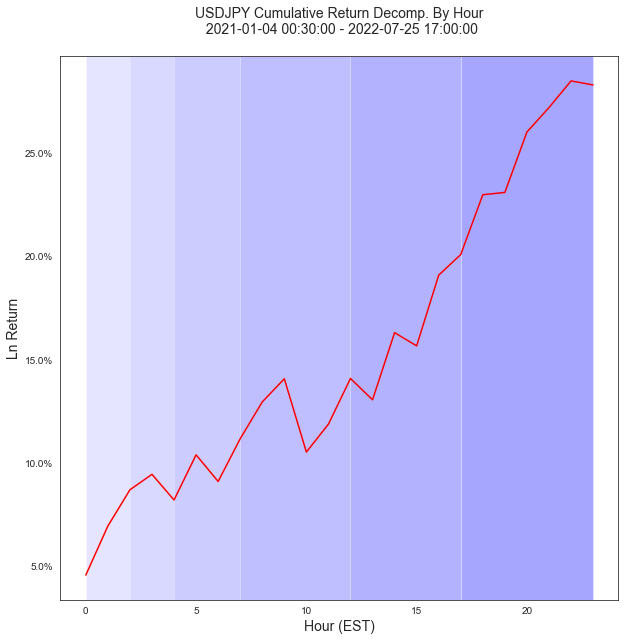

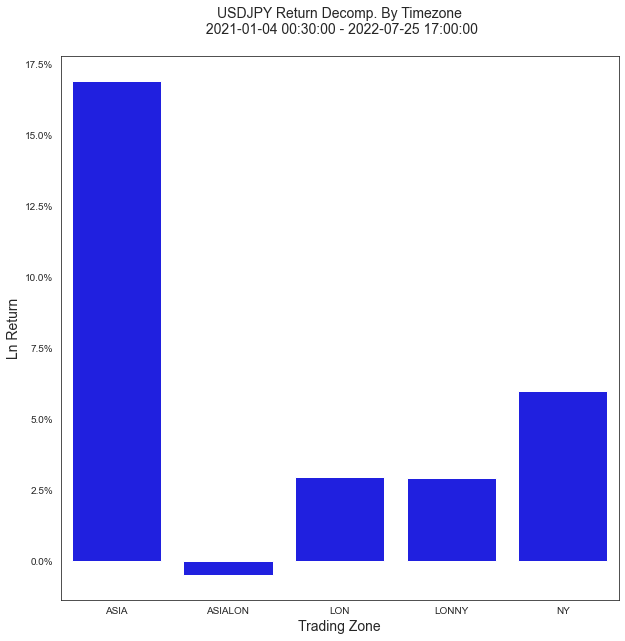

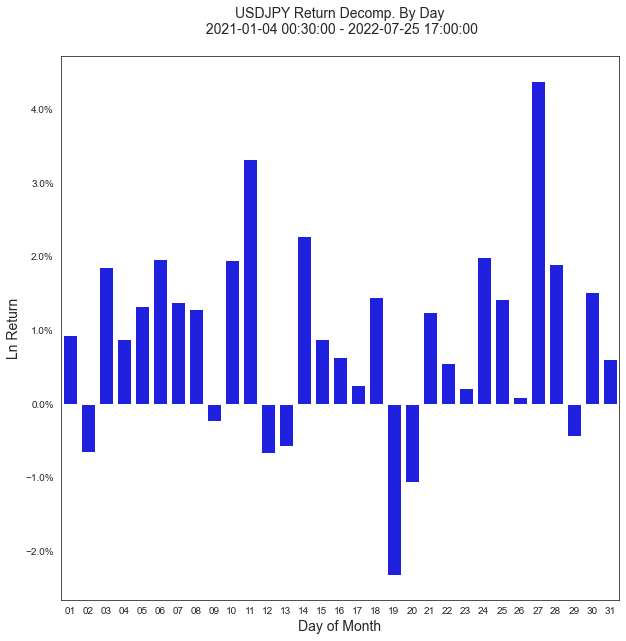

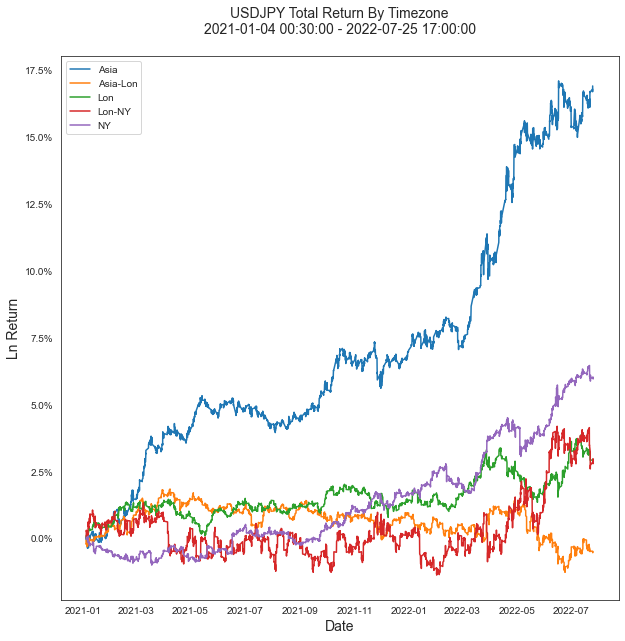

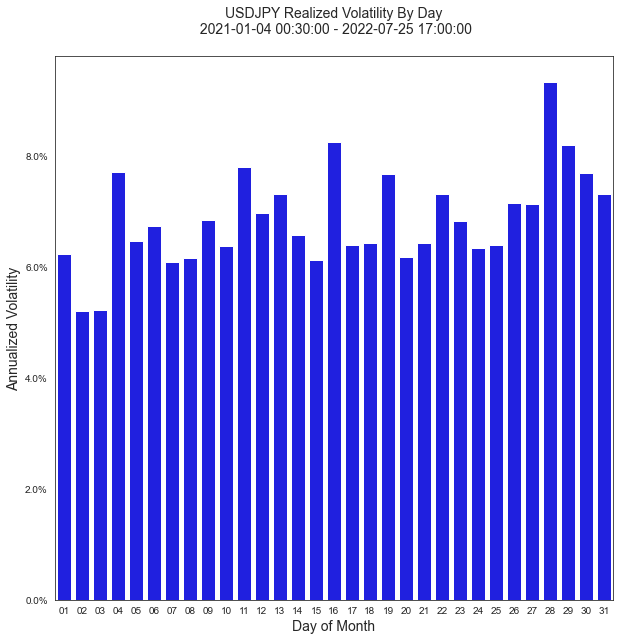

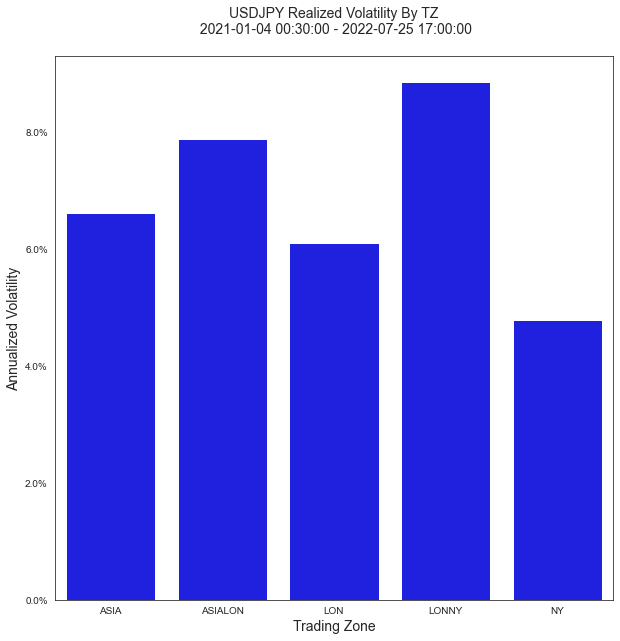

In [55]:
tz_distribution("USDJPY", "20210101", "20220725")


,Value,Timestamp,Hour,Zone,Day
2021-01-04 00:30:00,-0.000286,2021-01-04 00:30:00,0,ASIA,04
2021-01-04 01:00:00,0.000898,2021-01-04 01:00:00,1,ASIA,04
2021-01-04 01:30:00,-0.000775,2021-01-04 01:30:00,1,ASIA,04
2021-01-04 02:00:00,0.000857,2021-01-04 02:00:00,2,ASIA,04
2021-01-04 02:30:00,0.000612,2021-01-04 02:30:00,2,ASIA,04
...,...,...,...,...,...
2022-07-25 15:00:00,-0.000391,2022-07-25 15:00:00,15,NY,25
2022-07-25 15:30:00,0.000391,2022-07-25 15:30:00,15,NY,25
2022-07-25 16:00:00,0.000000,2022-07-25 16:00:00,16,NY,25
2022-07-25 16:30:00,0.000000,2022-07-25 16:30:00,16,NY,25


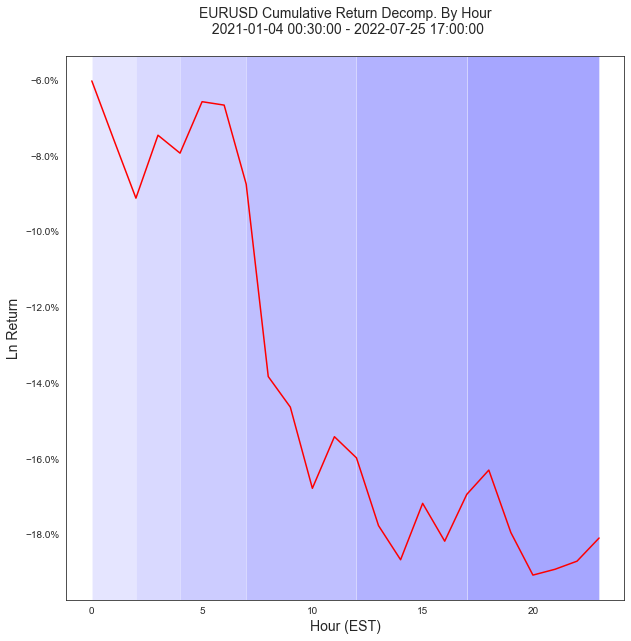

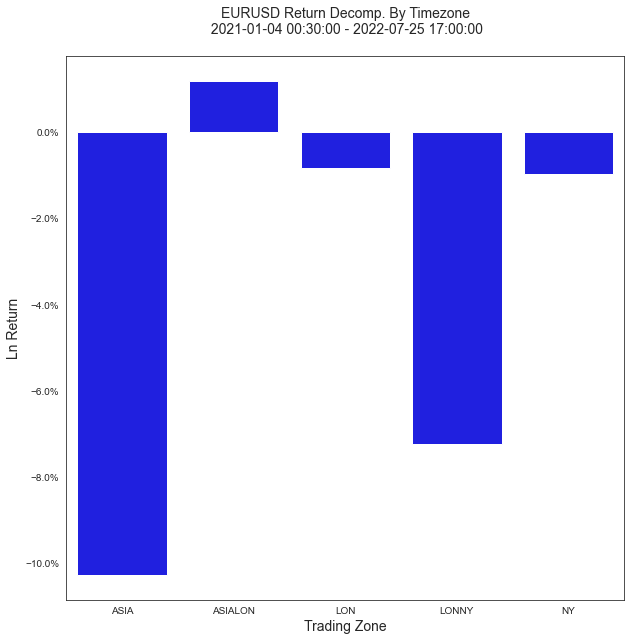

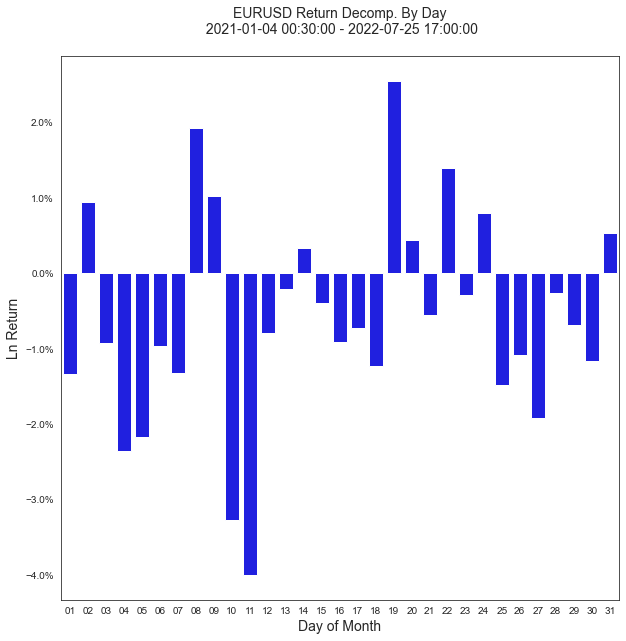

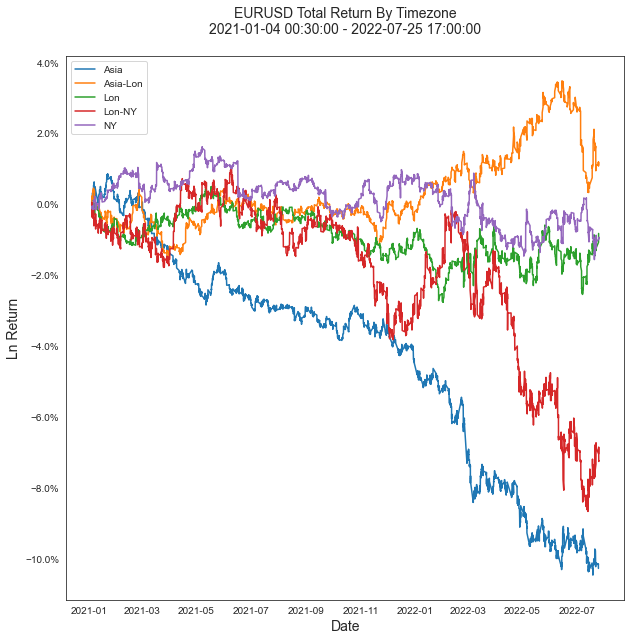

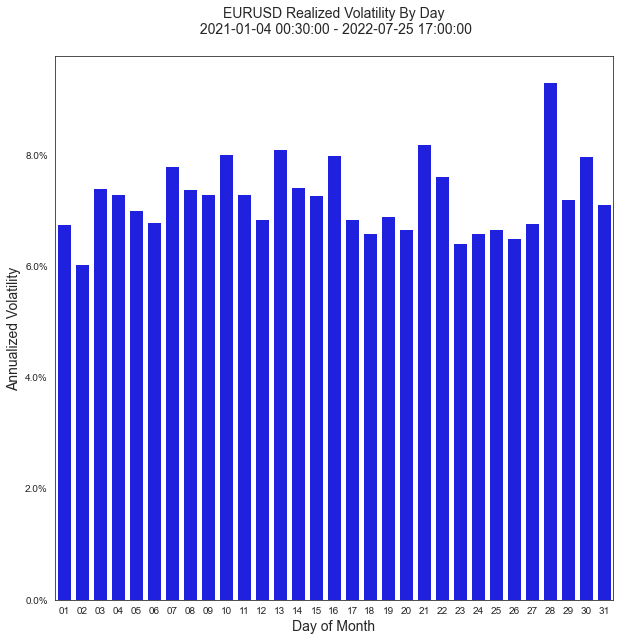

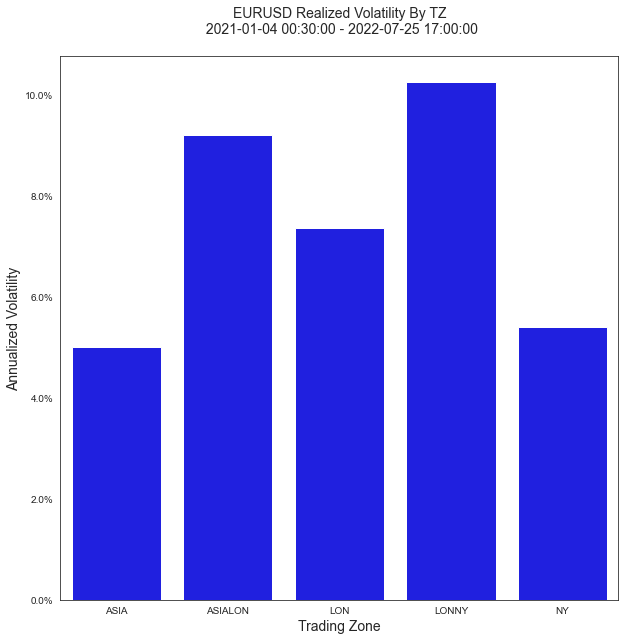

In [56]:
tz_distribution("EURUSD", "20210101", "20220725")

,Value,Timestamp,Hour,Zone,Day
2021-01-04 00:30:00,-0.001104,2021-01-04 00:30:00,0,ASIA,04
2021-01-04 01:00:00,0.001688,2021-01-04 01:00:00,1,ASIA,04
2021-01-04 01:30:00,0.000259,2021-01-04 01:30:00,1,ASIA,04
2021-01-04 02:00:00,0.000778,2021-01-04 02:00:00,2,ASIA,04
2021-01-04 02:30:00,0.001036,2021-01-04 02:30:00,2,ASIA,04
...,...,...,...,...,...
2022-07-25 15:00:00,-0.000503,2022-07-25 15:00:00,15,NY,25
2022-07-25 15:30:00,0.000575,2022-07-25 15:30:00,15,NY,25
2022-07-25 16:00:00,0.000503,2022-07-25 16:00:00,16,NY,25
2022-07-25 16:30:00,-0.000503,2022-07-25 16:30:00,16,NY,25


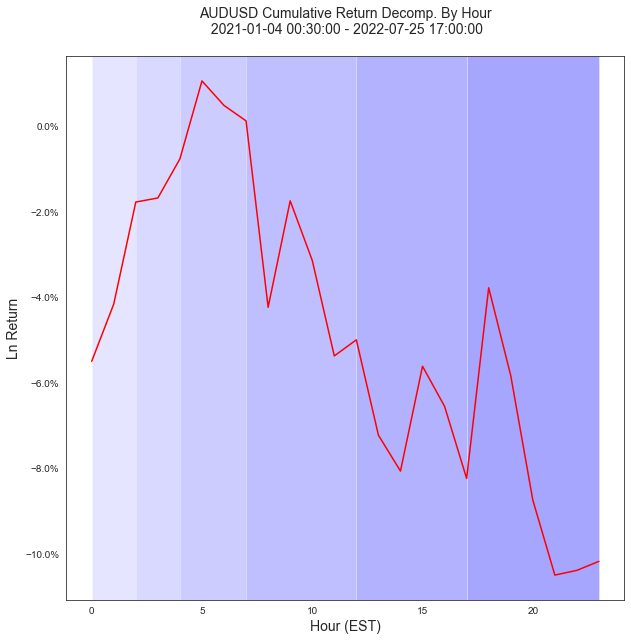

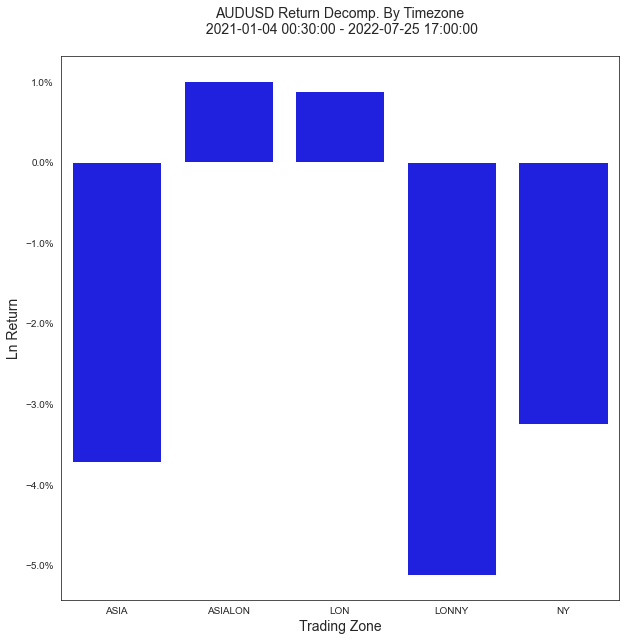

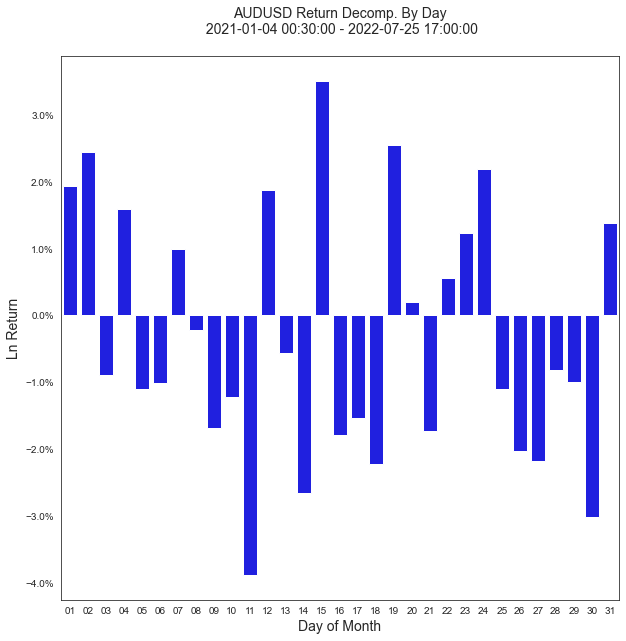

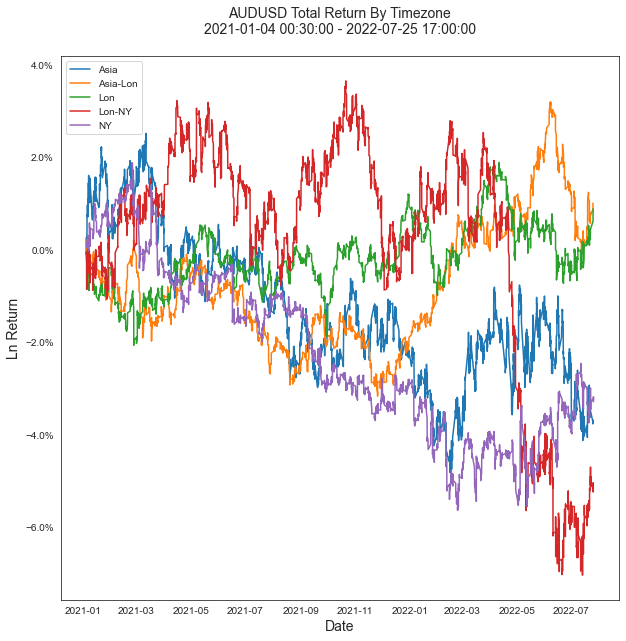

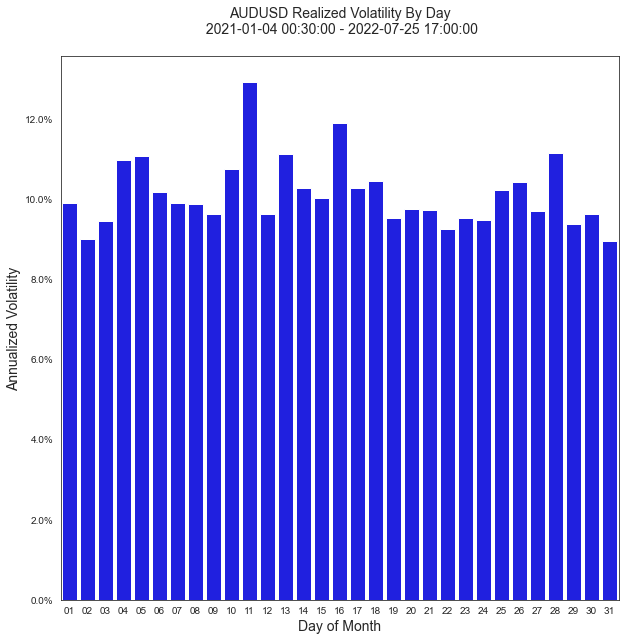

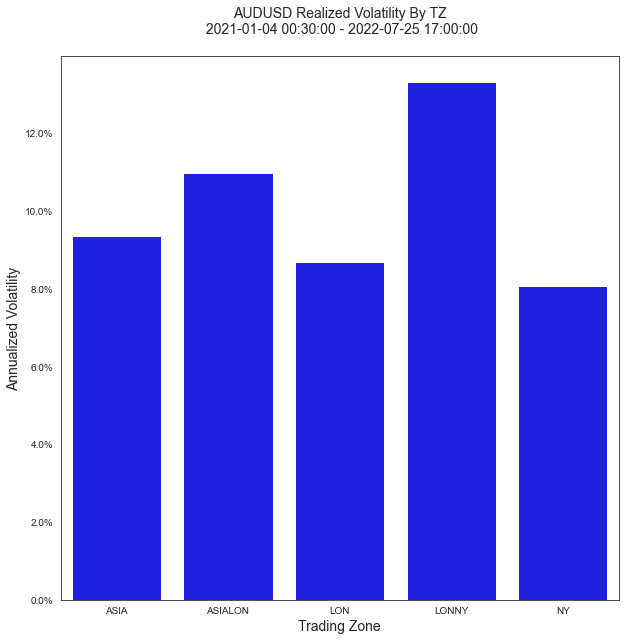

In [57]:
tz_distribution("AUDUSD", "20210101", "20220725")

,Value,Timestamp,Hour,Zone,Day
2021-01-04 00:30:00,0.000511,2021-01-04 00:30:00,0,ASIA,04
2021-01-04 01:00:00,-0.000315,2021-01-04 01:00:00,1,ASIA,04
2021-01-04 01:30:00,0.000118,2021-01-04 01:30:00,1,ASIA,04
2021-01-04 02:00:00,-0.000590,2021-01-04 02:00:00,2,ASIA,04
2021-01-04 02:30:00,-0.000473,2021-01-04 02:30:00,2,ASIA,04
...,...,...,...,...,...
2022-07-25 15:00:00,0.000234,2022-07-25 15:00:00,15,NY,25
2022-07-25 15:30:00,-0.000234,2022-07-25 15:30:00,15,NY,25
2022-07-25 16:00:00,-0.000506,2022-07-25 16:00:00,16,NY,25
2022-07-25 16:30:00,0.000350,2022-07-25 16:30:00,16,NY,25


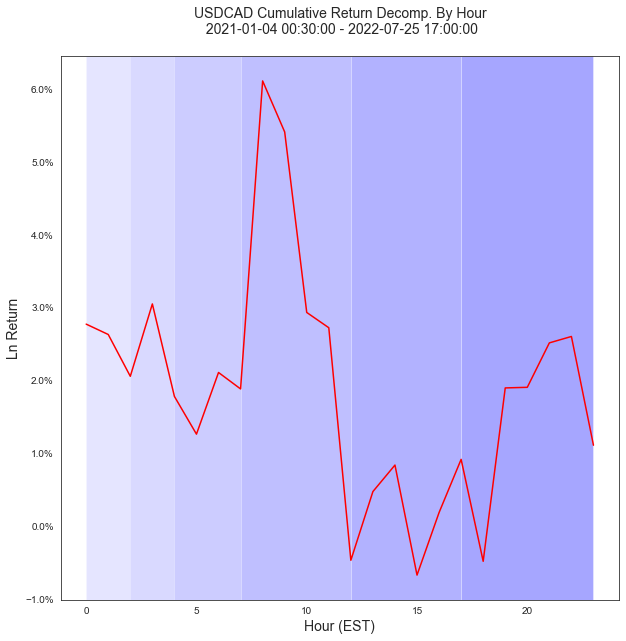

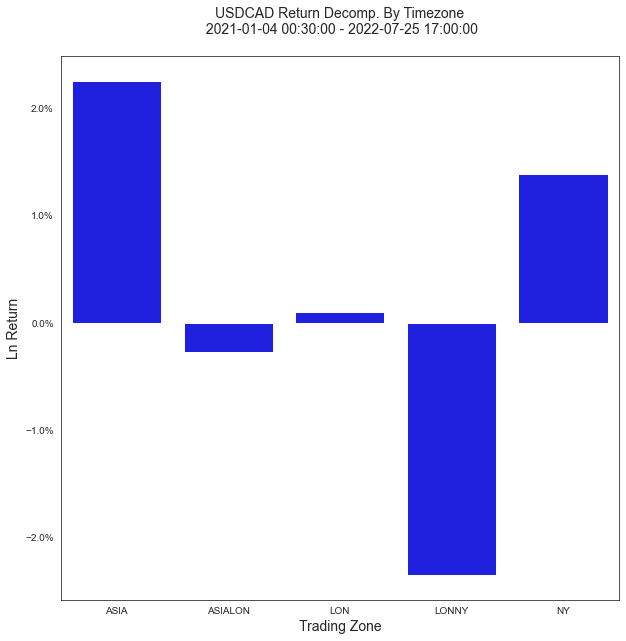

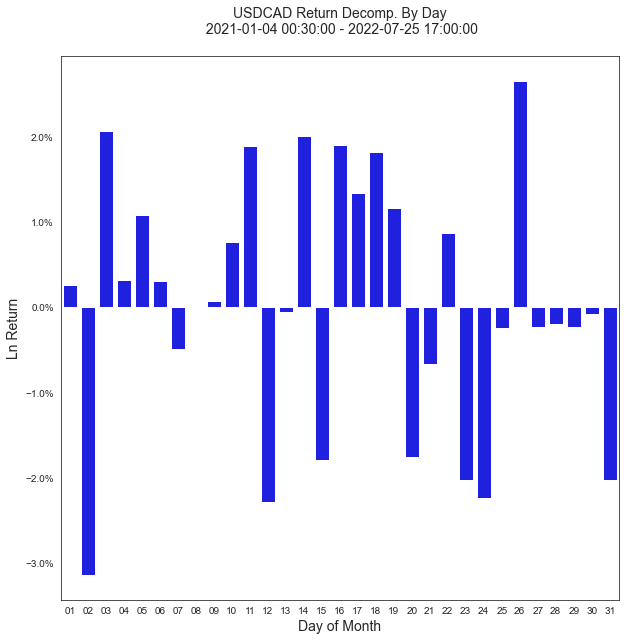

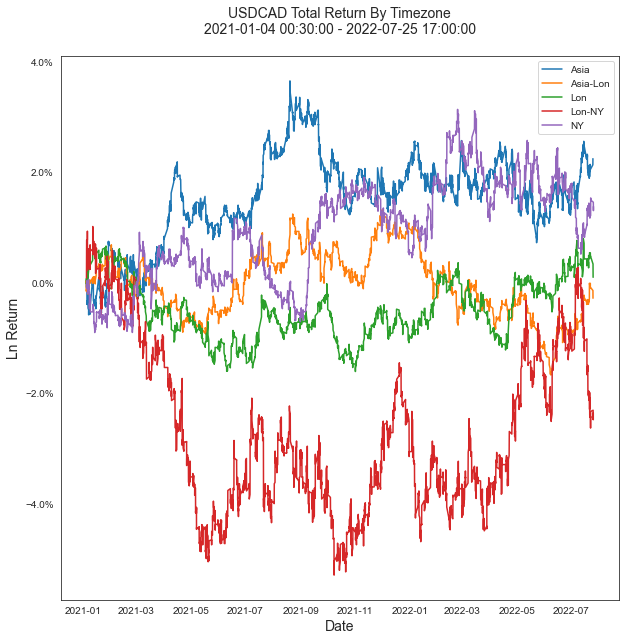

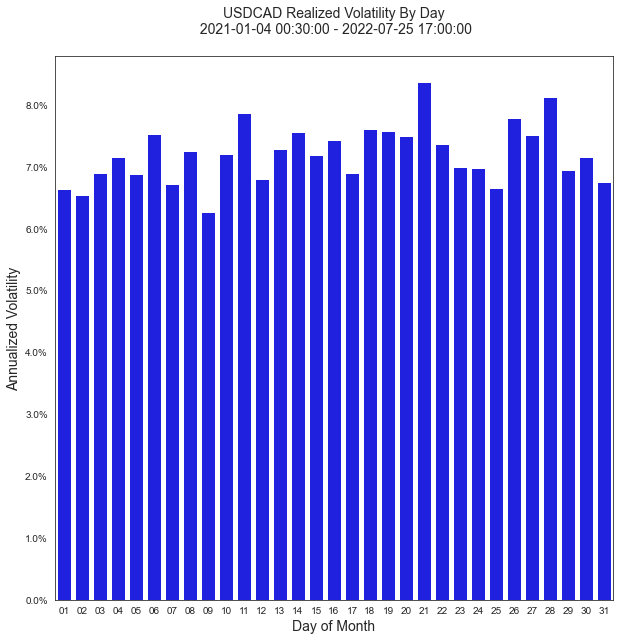

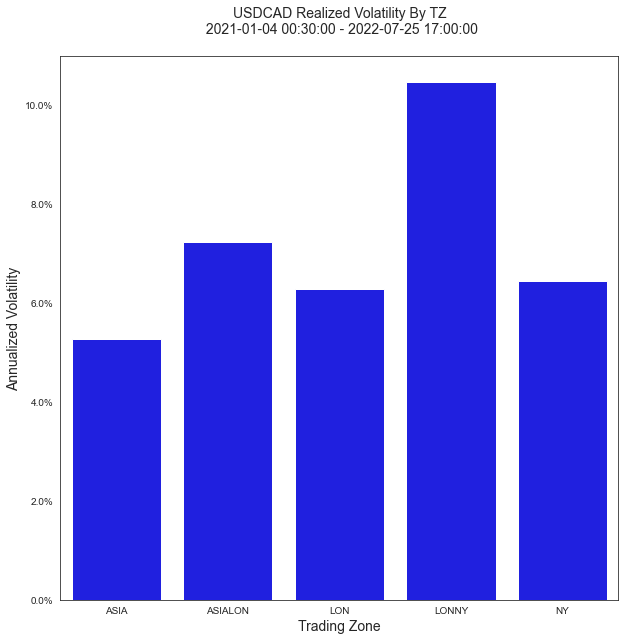

In [58]:
tz_distribution("USDCAD", "20210101", "20220725")

,Value,Timestamp,Hour,Zone,Day
2021-01-04 00:30:00,0.000414,2021-01-04 00:30:00,0,ASIA,04
2021-01-04 01:00:00,0.000358,2021-01-04 01:00:00,1,ASIA,04
2021-01-04 01:30:00,0.001840,2021-01-04 01:30:00,1,ASIA,04
2021-01-04 02:00:00,-0.001255,2021-01-04 02:00:00,2,ASIA,04
2021-01-04 02:30:00,-0.000071,2021-01-04 02:30:00,2,ASIA,04
...,...,...,...,...,...
2022-07-25 15:00:00,0.000827,2022-07-25 15:00:00,15,NY,25
2022-07-25 15:30:00,0.001369,2022-07-25 15:30:00,15,NY,25
2022-07-25 16:00:00,-0.000318,2022-07-25 16:00:00,16,NY,25
2022-07-25 16:30:00,0.000684,2022-07-25 16:30:00,16,NY,25


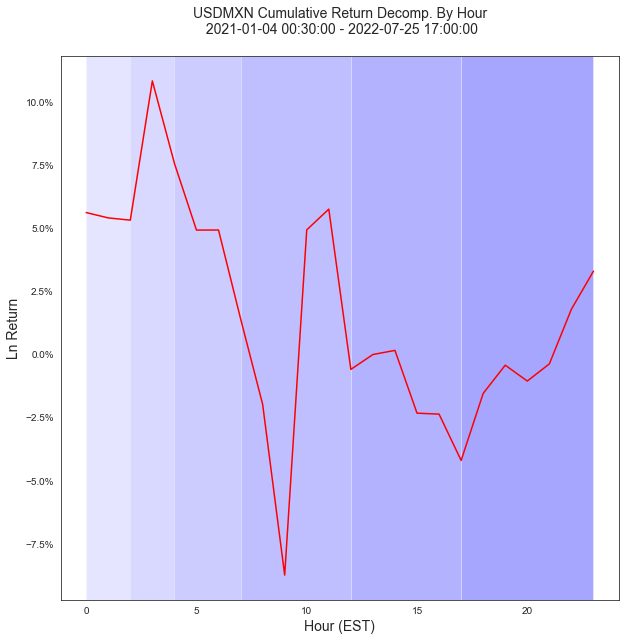

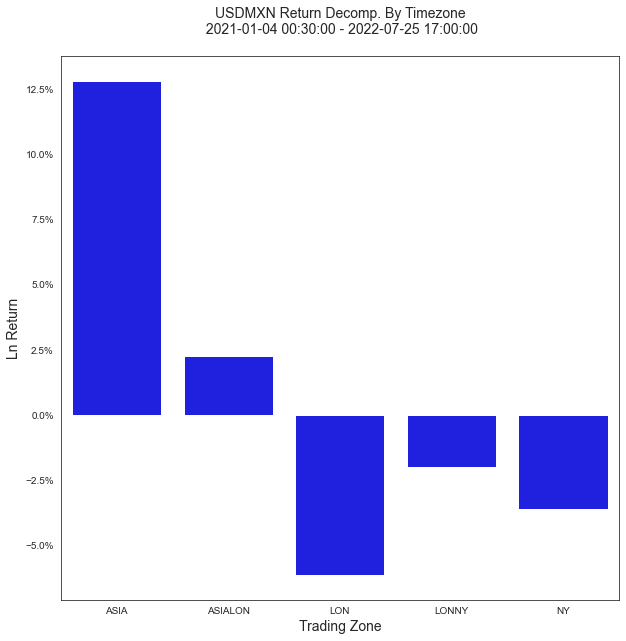

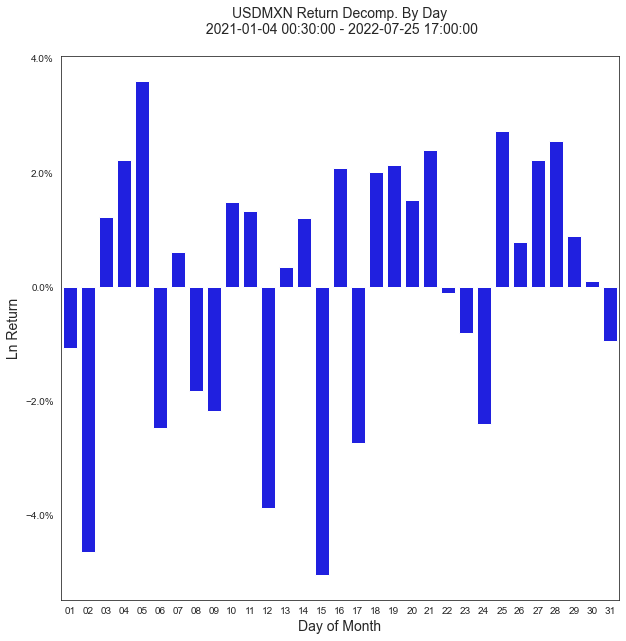

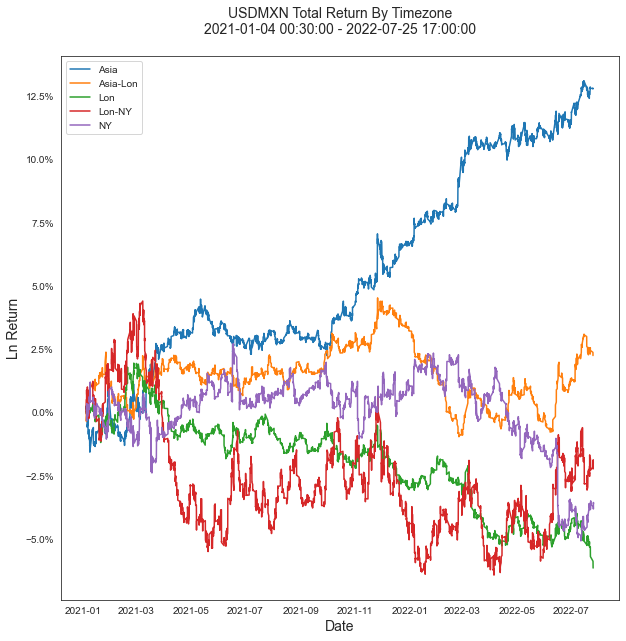

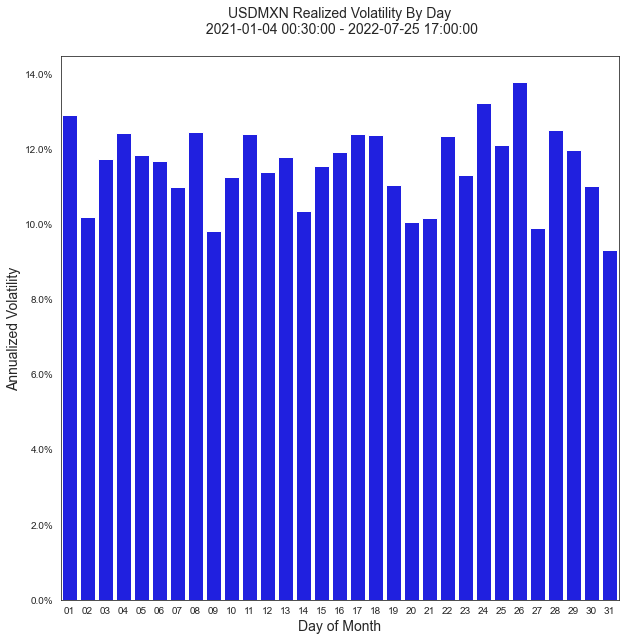

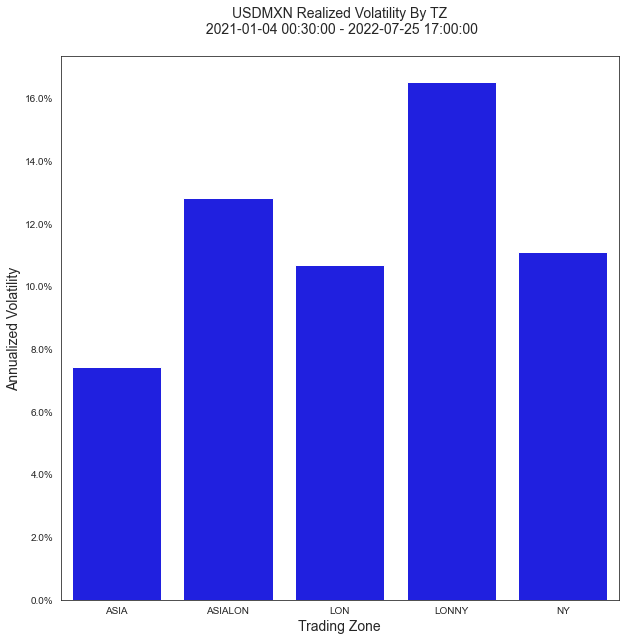

In [59]:
tz_distribution("USDMXN", "20210101", "20220725")